### Install and Import Tensorflow

In [1]:
#!pip3 install --upgrade pip
#!pip --version
#!pip3 install tensorflow
#!pip3 install tensorflow-gpu
#!pip3 list | grep "tensorflow"
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
import csv
import json
import tensorflow as tf
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

In [3]:
!pwd

/home/cdsw/sentiment_analysis


### Download the Sentiment140 data

In [4]:
##Download from the Stanford link
!wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip -o data/sentiment140_training_and_test_data.zip
# Move the file to the "data" folder and rename it to 'sentiment140_training_and_test_data.zip'

--2020-09-15 14:48:29--  http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip [following]
--2020-09-15 14:48:29--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘trainingandtestdata.zip’

trainingandtestdata 100%[===================>]  77.59M  47.7MB/s    in 1.6s    

2020-09-15 14:48:31 (47.7 MB/s) - ‘trainingandtestdata.zip’ saved [81363704/81363704]



In [5]:
##Unzip
import zipfile
with zipfile.ZipFile("data/sentiment140_training_and_test_data.zip","r") as zip_ref:
    zip_ref.extractall("data/sentiment140_unzipped")

In [6]:
##Remove the LATIN1 encoding to make it easier for Python CSV reader
!iconv -f LATIN1 -t UTF8 data/sentiment140_unzipped/training.1600000.processed.noemoticon.csv -o data/sentiment140_cleaned.csv


In [7]:
embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=1600000
test_portion=.1

In [8]:
count_positive = 0
count_neutral = 0
count_negative = 0

with open("data/sentiment140_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        label_only=row[0]
        if label_only=='0':
            count_negative = count_negative + 1
        elif label_only=='2':
            count_neutral = count_neutral + 1
        else:
            count_positive = count_positive + 1

print("Positive : " + str(count_positive))
print("Negative : " + str(count_negative))
print("Neutral : " + str(count_neutral))

Positive : 800000
Negative : 800000
Neutral : 0


In [9]:
num_sentences = 0
corpus = []

with open("data/sentiment140_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        text_and_label=[]
        text_and_label.append(row[5])
        label_only=row[0]
        if label_only=='0':
            text_and_label.append(0)
        else:
            text_and_label.append(1)
        num_sentences = num_sentences + 1
        corpus.append(text_and_label)

In [10]:
print(num_sentences)
print(len(corpus))
print(corpus[20])

1600000
1600000
["@alydesigns i was out most of the day so didn't get much done ", 0]


In [11]:
all_labels = [item[1] for item in corpus]
unique_labels = set(all_labels)
unique_labels

{0, 1}

### Data Preparation

In [12]:
all_sentences=[]
all_labels=[]
random.shuffle(corpus)
for x in range(training_size):
    all_sentences.append(corpus[x][0])
    all_labels.append(corpus[x][1])


tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(all_sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sent_sequences = tokenizer.texts_to_sequences(all_sentences)
padded_sent = pad_sequences(sent_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

split = int(test_portion * training_size)

test_sequences = padded_sent[0:split]
training_sequences = padded_sent[split:training_size]
test_labels = all_labels[0:split]
training_labels = all_labels[split:training_size]

In [13]:
print(type(training_sequences))
print(type(training_labels))

<class 'numpy.ndarray'>
<class 'list'>


In [14]:
print(training_sequences.shape)
print(len(training_labels))
print(test_sequences.shape)
print(len(test_labels))

(1440000, 16)
1440000
(160000, 16)
160000


In [15]:
print(vocab_size)
print(word_index['the'])
print(word_index['<OOV>'])

690961
4
1


### GloVe Embeddings

In [16]:
!wget http://nlp.stanford.edu/data/glove.6B.zip -O embeddings/glove.6B.zip

--2020-09-15 14:51:55--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-09-15 14:51:55--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-09-15 14:51:56--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘embeddings/glove.6B.zi

In [17]:
##Unzip
import zipfile
with zipfile.ZipFile("embeddings/glove.6B.zip","r") as zip_ref:
    zip_ref.extractall("embeddings/glove_6B")

In [18]:
embedding_dict = {};
with open('embeddings/glove_6B/glove.6B.100d.txt') as f:
    for item in f:
        embed_items = item.split();
        word = embed_items[0];
        word_vec = np.asarray(embed_items[1:], dtype='float32');
        embedding_dict[word] = word_vec;

embedding_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embedding_dict.get(word);
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector;

In [19]:
embedding_matrix.shape

(690962, 100)

In [20]:
vocab_size

690961

In [21]:
from itertools import islice

def take(n, iterable):
    return list(islice(iterable, n))

n_items = take(20, word_index.items())
print(n_items)

[('<OOV>', 1), ('i', 2), ('to', 3), ('the', 4), ('a', 5), ('my', 6), ('and', 7), ('you', 8), ('is', 9), ('it', 10), ('in', 11), ('for', 12), ('of', 13), ('on', 14), ('me', 15), ('so', 16), ('have', 17), ('that', 18), ('but', 19), ("i'm", 20)]


In [22]:
print(word_index["i'm"])
print(word_index["i've"])

20
152


In [23]:
embedding_dict['my']

array([ 0.080273 , -0.10861  ,  0.72067  , -0.45136  , -0.7496   ,
        0.63782  , -0.25705  ,  0.41606  , -0.054465 ,  0.35563  ,
        0.35864  ,  0.54004  ,  0.4912   ,  0.25711  , -0.21468  ,
       -0.42837  , -0.42318  ,  0.3872   , -0.35692  ,  0.40116  ,
       -0.19851  ,  0.43449  , -0.36478  ,  0.07172  ,  0.53324  ,
        0.84556  , -0.6754   , -1.2527   ,  0.83759  , -0.15925  ,
        0.37801  ,  0.94539  ,  0.83069  ,  0.19429  , -0.58449  ,
        0.5828   , -0.62559  ,  0.4904   ,  0.43273  , -0.54246  ,
        0.1045   , -0.16255  ,  0.98995  , -0.74219  , -0.59784  ,
        0.10189  , -0.3357   , -0.39094  ,  0.15132  , -1.3533   ,
       -0.11264  ,  0.14345  ,  0.038112 ,  1.1167   , -0.23078  ,
       -2.6394   ,  0.66849  ,  0.48452  ,  1.8796   ,  0.080274 ,
        0.73728  ,  1.8058   , -0.51933  ,  0.0040521,  0.76986  ,
        0.36875  ,  0.81137  ,  0.16941  , -0.1192   , -0.26496  ,
        0.22689  ,  0.76942  ,  0.85197  , -0.97773  ,  0.2317

In [24]:
embedding_matrix[5]

array([-0.27085999,  0.044006  , -0.02026   , -0.17395   ,  0.6444    ,
        0.71213001,  0.35510001,  0.47138   , -0.29637   ,  0.54426998,
       -0.72294003, -0.0047612 ,  0.040611  ,  0.043236  ,  0.29729   ,
        0.10725   ,  0.40156001, -0.53662002,  0.033382  ,  0.067396  ,
        0.64556003, -0.085523  ,  0.14103   ,  0.094539  ,  0.74947   ,
       -0.19400001, -0.68739003, -0.41740999, -0.22807001,  0.12      ,
       -0.48999   ,  0.80944997,  0.045138  , -0.11898   ,  0.20161   ,
        0.39276001, -0.20121001,  0.31354001,  0.75304002,  0.25907001,
       -0.11566   , -0.029319  ,  0.93498999, -0.36067   ,  0.52420002,
        0.23706   ,  0.52714998,  0.22869   , -0.51958001, -0.79348999,
       -0.20367999, -0.50186998,  0.18748   ,  0.94282001, -0.44834   ,
       -3.67919993,  0.044183  , -0.26751   ,  2.19970012,  0.241     ,
       -0.033425  ,  0.69553   , -0.64472002, -0.0072277 ,  0.89574999,
        0.20015   ,  0.46493   ,  0.61932999, -0.1066    ,  0.08

### Build Model and Train

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Conv1D(32, 8, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 100)           69096200  
_________________________________________________________________
conv1d (Conv1D)              (None, 9, 32)             25632     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4, 32)             0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 32)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                5

In [26]:
num_epochs = 100
batch_size = 16000
history = model.fit(np.array(training_sequences), np.array(training_labels), batch_size=batch_size, epochs=num_epochs, validation_data=(np.array(test_sequences), np.array(test_labels)), verbose=2)

print("Training Complete!")

Epoch 1/100
90/90 - 6s - loss: 0.6284 - acc: 0.6500 - val_loss: 0.5651 - val_acc: 0.7065
Epoch 2/100
90/90 - 5s - loss: 0.5646 - acc: 0.7133 - val_loss: 0.5342 - val_acc: 0.7272
Epoch 3/100
90/90 - 5s - loss: 0.5450 - acc: 0.7273 - val_loss: 0.5218 - val_acc: 0.7363
Epoch 4/100
90/90 - 5s - loss: 0.5344 - acc: 0.7355 - val_loss: 0.5142 - val_acc: 0.7414
Epoch 5/100
90/90 - 5s - loss: 0.5281 - acc: 0.7400 - val_loss: 0.5095 - val_acc: 0.7449
Epoch 6/100
90/90 - 5s - loss: 0.5229 - acc: 0.7434 - val_loss: 0.5049 - val_acc: 0.7485
Epoch 7/100
90/90 - 5s - loss: 0.5193 - acc: 0.7459 - val_loss: 0.5015 - val_acc: 0.7501
Epoch 8/100
90/90 - 5s - loss: 0.5163 - acc: 0.7482 - val_loss: 0.4991 - val_acc: 0.7515
Epoch 9/100
90/90 - 5s - loss: 0.5138 - acc: 0.7498 - val_loss: 0.4973 - val_acc: 0.7532
Epoch 10/100
90/90 - 5s - loss: 0.5113 - acc: 0.7513 - val_loss: 0.4951 - val_acc: 0.7551
Epoch 11/100
90/90 - 5s - loss: 0.5096 - acc: 0.7525 - val_loss: 0.4962 - val_acc: 0.7539
Epoch 12/100
90/90 

90/90 - 5s - loss: 0.4826 - acc: 0.7692 - val_loss: 0.4781 - val_acc: 0.7663
Epoch 93/100
90/90 - 5s - loss: 0.4826 - acc: 0.7689 - val_loss: 0.4773 - val_acc: 0.7667
Epoch 94/100
90/90 - 5s - loss: 0.4825 - acc: 0.7692 - val_loss: 0.4777 - val_acc: 0.7665
Epoch 95/100
90/90 - 5s - loss: 0.4823 - acc: 0.7692 - val_loss: 0.4777 - val_acc: 0.7663
Epoch 96/100
90/90 - 5s - loss: 0.4825 - acc: 0.7693 - val_loss: 0.4770 - val_acc: 0.7671
Epoch 97/100
90/90 - 5s - loss: 0.4822 - acc: 0.7695 - val_loss: 0.4779 - val_acc: 0.7657
Epoch 98/100
90/90 - 5s - loss: 0.4826 - acc: 0.7692 - val_loss: 0.4799 - val_acc: 0.7638
Epoch 99/100
90/90 - 5s - loss: 0.4824 - acc: 0.7690 - val_loss: 0.4767 - val_acc: 0.7669
Epoch 100/100
90/90 - 5s - loss: 0.4821 - acc: 0.7693 - val_loss: 0.4771 - val_acc: 0.7672
Training Complete!


In [27]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

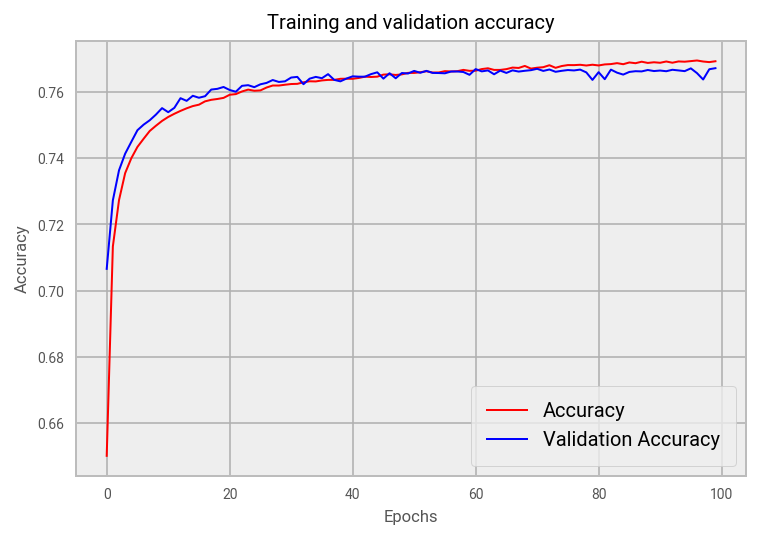

In [28]:
#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

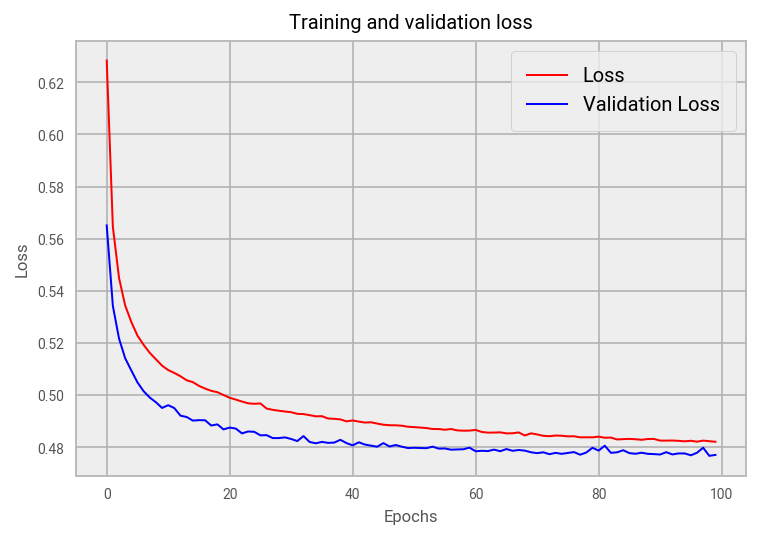

In [29]:
#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()

### Save the Model

In [30]:
#!mkdir -p saved_models

In [31]:
##Save the model
model.save('saved_models/model_conv1D_LSTM_with_batch_100_epochs_all')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_models/model_conv1D_LSTM_with_batch_100_epochs_all/assets


In [32]:
new_model = tf.keras.models.load_model('saved_models/model_conv1D_LSTM_with_batch_100_epochs_all')

# Check its architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 100)           69096200  
_________________________________________________________________
conv1d (Conv1D)              (None, 9, 32)             25632     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4, 32)             0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 32)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                5

### H5 format

In [33]:
import h5py

#Save the model as an h5 file
model.save('saved_models/model_conv1D_LSTM_with_batch_100_epochs.h5')

In [34]:
# Recreate the exact same model, including its weights and the optimizer
model_h5 = tf.keras.models.load_model('saved_models/model_conv1D_LSTM_with_batch_100_epochs.h5')

# Show the model architecture
model_h5.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 100)           69096200  
_________________________________________________________________
conv1d (Conv1D)              (None, 9, 32)             25632     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4, 32)             0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 32)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                5

### Saving the Tokenizer

In [35]:
import pickle

# saving
with open('saved_models/sentiment140_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [36]:
# loading
with open('saved_models/sentiment140_tokenizer.pickle', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)

In [37]:
loaded_word_index = loaded_tokenizer.word_index
n_items = take(20, loaded_word_index.items())
print(n_items)

[('<OOV>', 1), ('i', 2), ('to', 3), ('the', 4), ('a', 5), ('my', 6), ('and', 7), ('you', 8), ('is', 9), ('it', 10), ('in', 11), ('for', 12), ('of', 13), ('on', 14), ('me', 15), ('so', 16), ('have', 17), ('that', 18), ('but', 19), ("i'm", 20)]


### Predictions

In [38]:
train_loss, train_acc = model.evaluate(np.array(training_sequences), np.array(training_labels), verbose=0)
print('Training Accuracy: %f%% ' % (train_acc*100))

Training Accuracy: 78.174096% 


In [39]:
loss, acc = model.evaluate(np.array(test_sequences), np.array(test_labels), verbose=0)
print('Test Accuracy: %f%% ' % (acc*100))

Test Accuracy: 76.720625% 


In [40]:
def text_prep(sent):
    sent = np.array([sent])
    sequences = tokenizer.texts_to_sequences(sent)
    padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    return padded

In [41]:
test_example = text_prep("What a great and beautiful day")
pred_conf = model.predict(test_example)
pred_class = (model.predict(test_example) > 0.5).astype("int32")
print("%s sentiment; %f%% confidence" % (pred_class[0][0], pred_conf[0][np.argmax(pred_conf)] * 100))

1 sentiment; 98.026890% confidence


In [42]:
test_example = text_prep("I'm having a terrible day!")
pred_conf = model.predict(test_example)
pred_class = (model.predict(test_example) > 0.5).astype("int32")
print("%s sentiment; %f%% confidence" % (pred_class[0][0], pred_conf[0][np.argmax(pred_conf)] * 100))

0 sentiment; 1.002248% confidence


In [43]:
test_example = text_prep("I'm having an awesome day")
pred_conf = model.predict(test_example)
pred_class = (model.predict(test_example) > 0.5).astype("int32")
print("%s sentiment; %f%% confidence" % (pred_class[0][0], pred_conf[0][np.argmax(pred_conf)] * 100))

1 sentiment; 96.461350% confidence


In [44]:
test_example = text_prep("I've had a long day!")
pred_conf = model.predict(test_example)
pred_class = (model.predict(test_example) > 0.5).astype("int32")
print("%s sentiment; %f%% confidence" % (pred_class[0][0], pred_conf[0][np.argmax(pred_conf)] * 100))

1 sentiment; 50.211382% confidence


In [45]:
test_example = text_prep("This is a bad example")
pred_conf = model.predict(test_example)
pred_class = (model.predict(test_example) > 0.5).astype("int32")
print("%s sentiment; %f%% confidence" % (pred_class[0][0], pred_conf[0][np.argmax(pred_conf)] * 100))

0 sentiment; 3.646842% confidence


In [46]:
test_example = text_prep("This is the worst ice-cream I've had")
pred_conf = model.predict(test_example)
pred_class = (model.predict(test_example) > 0.5).astype("int32")
print("%s sentiment; %f%% confidence" % (pred_class[0][0], pred_conf[0][np.argmax(pred_conf)] * 100))

0 sentiment; 4.250034% confidence


In [47]:
test_example = text_prep("This government is a failure!")
pred_conf = model.predict(test_example)
pred_class = (model.predict(test_example) > 0.5).astype("int32")
print("%s sentiment; %f%% confidence" % (pred_class[0][0], pred_conf[0][np.argmax(pred_conf)] * 100))

0 sentiment; 1.498488% confidence


In [48]:
test_example = text_prep("This government is a bad failure!")
pred_conf = model.predict(test_example)
pred_class = (model.predict(test_example) > 0.5).astype("int32")
print("%s sentiment; %f%% confidence" % (pred_class[0][0], pred_conf[0][np.argmax(pred_conf)] * 100))

0 sentiment; 1.650123% confidence


In [49]:
test_example = text_prep("They lost the elections!")
pred_conf = model.predict(test_example)
pred_class = (model.predict(test_example) > 0.5).astype("int32")
print("%s sentiment; %f%% confidence" % (pred_class[0][0], pred_conf[0][np.argmax(pred_conf)] * 100))

0 sentiment; 4.947440% confidence


In [50]:
test_example = text_prep("They won the elections!")
pred_conf = model.predict(test_example)
pred_class = (model.predict(test_example) > 0.5).astype("int32")
print("%s sentiment; %f%% confidence" % (pred_class[0][0], pred_conf[0][np.argmax(pred_conf)] * 100))

1 sentiment; 72.161716% confidence


In [51]:
test_example = text_prep("It's a bittersweet experience!")
pred_conf = model.predict(test_example)
pred_class = (model.predict(test_example) > 0.5).astype("int32")
print("%s sentiment; %f%% confidence" % (pred_class[0][0], pred_conf[0][np.argmax(pred_conf)] * 100))

1 sentiment; 70.937777% confidence


In [52]:
test_example = text_prep("I wish this gets over soon!")
pred_conf = model.predict(test_example)
pred_class = (model.predict(test_example) > 0.5).astype("int32")
print("%s sentiment; %f%% confidence" % (pred_class[0][0], pred_conf[0][np.argmax(pred_conf)] * 100))

0 sentiment; 4.648928% confidence


In [53]:
test_example = text_prep("Do not lose hope!")
pred_conf = model.predict(test_example)
pred_class = (model.predict(test_example) > 0.5).astype("int32")
print("%s sentiment; %f%% confidence" % (pred_class[0][0], pred_conf[0][np.argmax(pred_conf)] * 100))

0 sentiment; 11.430739% confidence


In [54]:
test_example = text_prep("This is the worst cake I've had")
pred_conf = model.predict(test_example)
pred_class = (model.predict(test_example) > 0.5).astype("int32")
print("%s sentiment; %f%% confidence" % (pred_class[0][0], pred_conf[0][np.argmax(pred_conf)] * 100))

0 sentiment; 3.242333% confidence


In [55]:
test_example = text_prep("We need better error messages")
pred_conf = model.predict(test_example)
pred_class = (model.predict(test_example) > 0.5).astype("int32")
print("%s sentiment; %f%% confidence" % (pred_class[0][0], pred_conf[0][np.argmax(pred_conf)] * 100))

0 sentiment; 13.750115% confidence


In [56]:
test_example = text_prep("In this situation, I'd say we are just being over confident")
pred_conf = model.predict(test_example)
pred_class = (model.predict(test_example) > 0.5).astype("int32")
print("%s sentiment; %f%% confidence" % (pred_class[0][0], pred_conf[0][np.argmax(pred_conf)] * 100))

0 sentiment; 42.576545% confidence


In [57]:
test_example = text_prep("You could have asked for an extra machine")
pred_conf = model.predict(test_example)
pred_class = (model.predict(test_example) > 0.5).astype("int32")
print("%s sentiment; %f%% confidence" % (pred_class[0][0], pred_conf[0][np.argmax(pred_conf)] * 100))

0 sentiment; 43.395936% confidence


In [58]:
test_example = text_prep("I'd take a bullet for him!")
pred_conf = model.predict(test_example)
pred_class = (model.predict(test_example) > 0.5).astype("int32")
print("%s sentiment; %f%% confidence" % (pred_class[0][0], pred_conf[0][np.argmax(pred_conf)] * 100))

1 sentiment; 64.831561% confidence
